In [33]:
from cosmikyu import visualization as covis
from cosmikyu import gan, config, datasets, transforms, stats, mpi, utils
import numpy as np
import os
import torchvision.transforms as pytransforms
#from torchvision import datasets
import matplotlib.pyplot as plt
import torch as tf
import mlflow
from orphics import maps
from pixell import enplot, enmap

%matplotlib inline
%load_ext autoreload
%autoreload 2

parallel = False
if parallel:
    import ipyparallel as ipp
    rc = ipp.Client()
    ar = rc[:].apply_async(os.getpid)
    pid_map = ar.get_dict()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [34]:
data_dir = config.default_data_dir
sehgal_dir = os.path.join(data_dir, 'sehgal')
cuda = True
compt_idxes = [0,1,2,3,4]
shape = (len(compt_idxes),128,128)
#shape = (1, 256, 256)
latent_dim = 64
sample_interval = 200
save_interval = 782
batch_size = 128
nepochs=50
#norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/normalization_info_fullv3.npz"
norm_info_file = "/home/dwhan89/workspace/cosmikyu/data/sehgal/082120_normalization_info_model.npz"


_, wcs = maps.rect_geometry(width_arcmin=64*5., height_arcmin=64, px_res_arcmin=0.5)

In [39]:
# Configure data loader
os.makedirs(data_dir, exist_ok=True)
os.makedirs(sehgal_dir, exist_ok=True)
SDN = transforms.SehgalDataNormalizerLogMinMax(norm_info_file)
SDUN = transforms.SehgalDataUnnormalizerLogMinMax(norm_info_file)
RF = transforms.RandomFlips(p_v=0.5, p_h=0.5)
SDS_test = datasets.SehgalDataSet(sehgal_dir, data_type="testv3", transforms=[SDN], dummy_label=False)

DCGAN_WGP = gan.DCGAN_WGP("sehgal_dcganwgp", shape, latent_dim, cuda=False, nconv_fcgen=64,
                          nconv_fcdis=64, ngpu=4, nconv_layer_gen=4, nconv_layer_disc=4, kernal_size=5, stride=2,
                          padding=2, output_padding=1)
experiment_id = "662d65640b6d44369a15a48127471f21"
model_dir = "/home/dwhan89/workspace/cosmikyu/output/sehgal_cosmoganwgpv4/{}/model".format(experiment_id)
print(model_dir)
DCGAN_WGP.load_states(model_dir)#, "_20")

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Traceback (most recent call last):
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 197, in list_experiments
    experiment = self._get_experiment(exp_id, view_type)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/store/tracking/file_store.py", line 260, in _get_experiment
    meta = read_yaml(experiment_dir, FileStore.META_DATA_FILE_NAME)
  File "/home/dwhan89/.miniconda3/lib/python3.7/site-packages/mlflow/utils/file_utils.py", line 167, in read_yaml
    raise MissingConfigException("Yaml file '%s' does not exist." % file_path)
mlflow.exceptions.M

[WARNING] You have a CUDA device. You probably want to run with CUDA enabled
/home/dwhan89/workspace/cosmikyu/output/sehgal_cosmoganwgpv4/662d65640b6d44369a15a48127471f21/model
loading saved states _35


In [36]:
bin_edges = np.linspace(-1.5,1.5,100)
nsample = len(SDS_test)
print(nsample)


30000


In [24]:


MB = stats.MultBinner(bin_edges, shape[0])
for idx in range(2000):#range(nsample):
    if idx % 1000 == 0: print(idx)
    MB.bin(SDS_test[idx])
    
ret = MB.get_info()
out = {}
for key in range(5):
    out[SDN.channel_idxes[key]] = ret[key].copy()
ret = out
np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/normalized_histogram_testv4.npz", **out)

0
1000


In [40]:
MB = stats.MultBinner(bin_edges, shape[0])
for idx in range(2000):
    if idx % 1000 == 0: print(idx)
    MB.bin(DCGAN_WGP.generate_samples(1).data.numpy()[0])
    
temp = MB.get_info()
generated = {}
for key in range(5):
    generated[SDN.channel_idxes[key]] = temp[key].copy()
np.savez("/home/dwhan89/workspace/cosmikyu/data/sehgal/normalized_histogram_generatedv4.npz", **generated)

0
1000


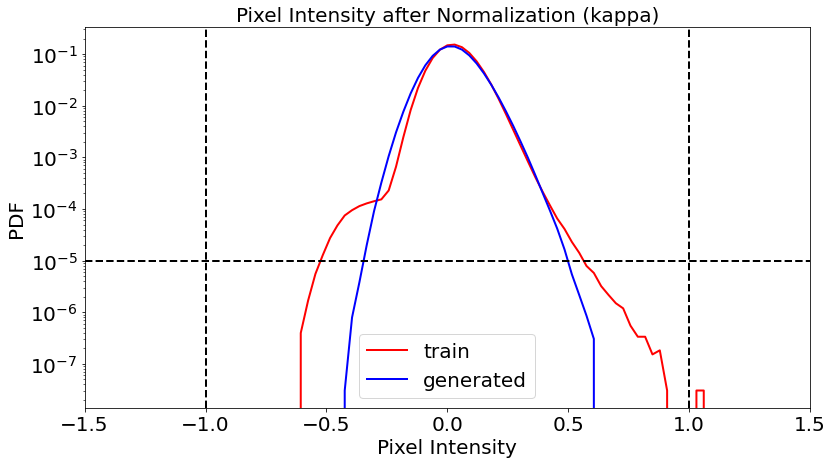

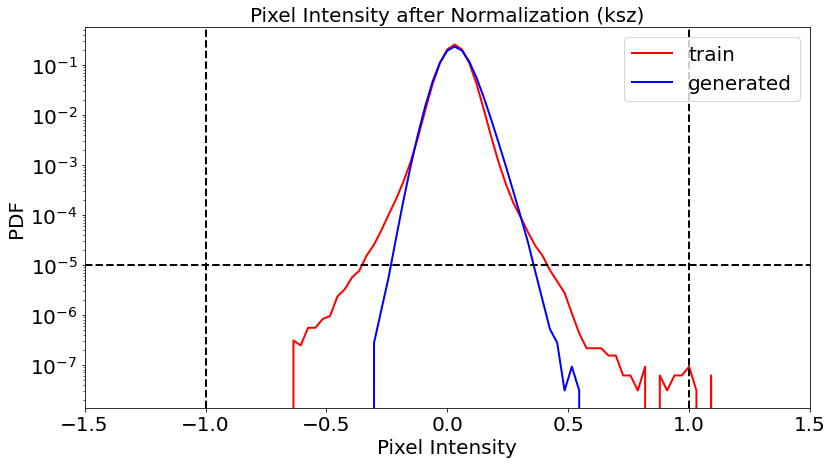

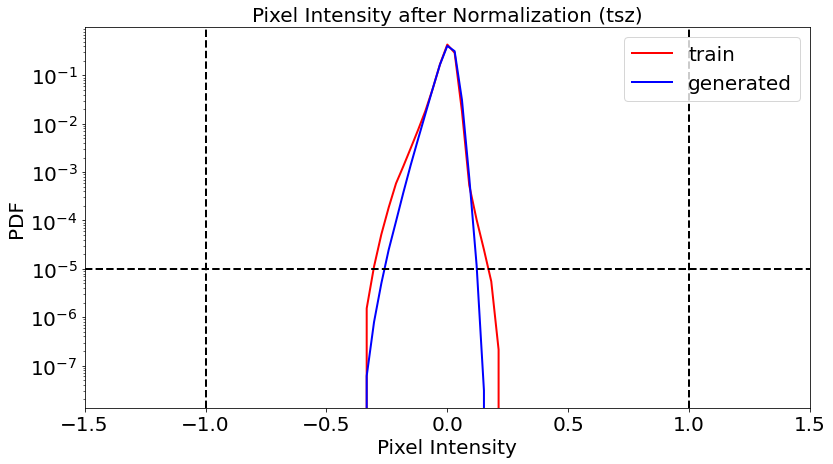

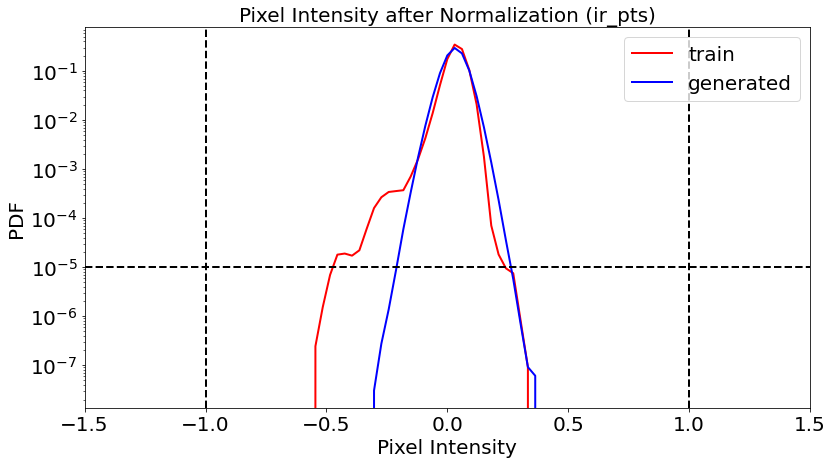

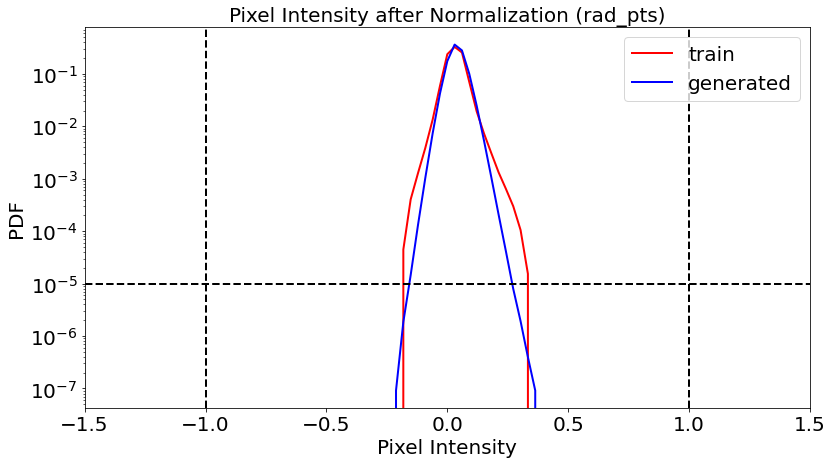

In [41]:
train =  utils.load_data("/home/dwhan89/workspace/cosmikyu/data/sehgal/normalized_histogram_testv4.npz")
generated = utils.load_data("/home/dwhan89/workspace/cosmikyu/data/sehgal/normalized_histogram_generatedv4.npz")

compts = ["kappa", "ksz", "tsz", "ir_pts", "rad_pts"]
for key in compts:
    fig = plt.figure(figsize=(13, 7))
    ax = fig.gca()
    hist_train = train[key]['hist']
    bins_train = train[key]["bin_centers"]
    nsum_trian = np.sum(hist_train)
    hist_train = hist_train/nsum_trian   
    plt.plot(bins_train, hist_train, alpha=1, ls="-", lw=2, color="r")
    
    hist_generated = generated[key]['hist']
    bins_generated = generated[key]["bin_centers"]
    nsum_generated = np.sum(hist_generated)
    hist_generated = hist_generated/nsum_generated   
    plt.plot(bins_generated, hist_generated, alpha=1, lw=2, ls="-", color="b")
    
    plt.plot([], [], label="train", ls="-", lw=2, color="r")
    plt.plot([], [], label="generated", ls="-", lw=2, color="b")

    plt.title("Pixel Intensity after Normalization (%s)"%key, fontsize=20)
    plt.xlabel("Pixel Intensity", fontsize=20)
    plt.ylabel("PDF", fontsize=20)
    plt.xlim(-1.5,1.5)
    ax.tick_params(axis='both', which='major', labelsize=20)
    ax.tick_params(axis='both', which='minor', labelsize=20)
    plt.legend(fontsize=20)
    #plt.ylim(-0.05,1)
    plt.axvline(x=1, ls="--", lw=2, color="k")
    plt.axvline(x=-1, ls="--", lw=2, color="k")
    plt.axhline(y=1e-5, ls="--", lw=2, color="k")
    plt.yscale("log")
    plt.show()

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['rad_pts', 'ir_pts', 'tsz', 'ksz', 'kappa']
Original Sehgal sim (64x64) arcmin^2


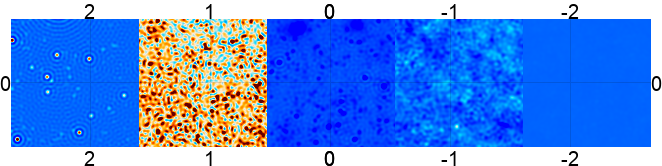

ML Reproduction (64x64) arcmin^2


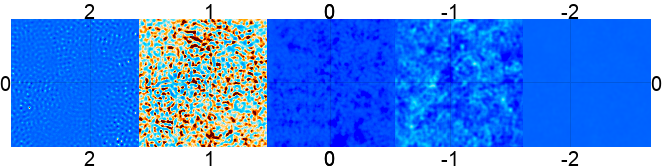

In [43]:
def make_hstrip(array):
    shape = array.shape
    if shape[0] < 2: return array
    else:
        nc, ny, nx = shape
        nnx = nx*nc
        ret = np.zeros((ny, nnx))
        for i in range(nc):
            sx = i*nx
            ret[:,sx:sx+nx] = array[i,...].copy()
        return ret

print(SDN.channel_idxes[::-1])
print("Original Sehgal sim (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(SDS_test[3])), wcs))
print("ML Reproduction (64x64) arcmin^2")
enplot.pshow(enmap.enmap(make_hstrip(SDUN(DCGAN_WGP.generate_samples(1).data.numpy()[0])), wcs))

In [55]:
enplot.write??

/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/home/dwhan89/.miniconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0 kappa
1 ksz
2 tsz
3 ir_pts
4 rad_pts
Original Sehgal+ Simulatons (2010)


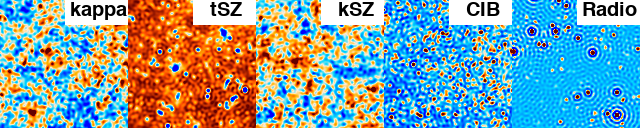

ML Reproduction


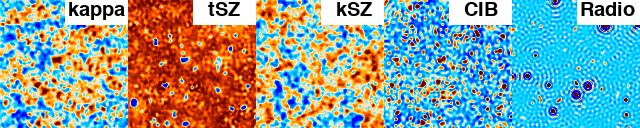

In [148]:
from PIL import Image
from IPython.display import display
from PIL import ImageFont
from PIL import ImageDraw 

#img = Image.open("sample_in.jpg")
#draw = ImageDraw.Draw(img)
# font = ImageFont.truetype(<font-file>, <font-size>)
#font = ImageFont.truetype("sans-serif.ttf", 16)
# draw.text((x, y),"Sample Text",(r,g,b))
#draw.text((0, 0),"Sample Text",(255,255,255),font=font)


plot_dir = os.path.join(config.default_output_dir, "plots")
def plot_path(x):
    return os.path.join(plot_dir, x)

_, wcs = maps.rect_geometry(width_arcmin=64., height_arcmin=64, px_res_arcmin=0.5)
emap_test = enmap.enmap(SDUN(SDS_test[10]), wcs)
np.random.seed(4)
emap_gen = enmap.enmap(SDUN(DCGAN_WGP.generate_samples(1).data.numpy()[0]), wcs)
for i, idx in enumerate(SDN.channel_idxes):
    print(i,idx)
    #enplot.pshow(emap_test[i], grid=False)
    #enplot.pshow(emap_gen[i], grid=False)
    plot_test = enplot.plot(emap_test[i], grid=False)
    plot_gen = enplot.plot(emap_gen[i], grid=False)
    
    enplot.write(plot_path("{}_test".format(idx)), plot_test)
    enplot.write(plot_path("{}_gen".format(idx)), plot_gen)
    
nimages = len(SDN.channel_idxes)
imgs_test = [None]*nimages
imgs_gen = [None]*nimages

titles = {"kappa": "kappa", "ksz": "  kSZ", "tsz": "  tSZ", "ir_pts": "  CIB", "rad_pts": "Radio"}

swap = [0,2,1,3,4]

for i, idx in enumerate([SDN.channel_idxes[i] for i in swap]):
    fontsize = 20 if idx == "kappa" else 20
    font = ImageFont.truetype("/home/dwhan89/.fonts/Helvetica-Bold.ttf", fontsize)
    imgs_test[i] = Image.open(plot_path("{}_test.png".format(idx)))
    draw = ImageDraw.Draw(imgs_test[i])
    
    draw.rectangle(((65, 0), (130, 24)), fill="white")
    draw.text((70, 0), titles[idx], fill="black",font=font)
    #display(imgs_test[i])
    
    imgs_gen[i] = Image.open(plot_path("{}_gen.png".format(idx)))
    draw = ImageDraw.Draw(imgs_gen[i])
    draw.rectangle(((65, 0), (130, 24)), fill="white")
    draw.text((68, 0), titles[idx], fill="black",font=font)
    #display(imgs_gen[i])

def get_concat_h(im1, im2):
    dst = Image.new('RGB', (im1.width + im2.width, im1.height))
    dst.paste(im1, (0, 0))
    dst.paste(im2, (im1.width, 0))
    return dst

strip_test = imgs_test[0].copy()
strip_gen = imgs_gen[0].copy()
for i in range(1,nimages):
    strip_test = get_concat_h(strip_test, imgs_test[i])
    strip_gen = get_concat_h(strip_gen, imgs_gen[i])
print("Original Sehgal+ Simulatons (2010)")
display(strip_test)
print("ML Reproduction")
display(strip_gen)